## Install all Libraries

In [45]:
!apt-get update
!apt-get install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install catboost
!pip install --upgrade scikit-learn
!pip install optuna

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 3s (89.0 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lis

In [46]:
import sys
import pandas as pd
import time
import re
from random import randint
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.preprocessing import PowerTransformer, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#model
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

#crosval
from sklearn.model_selection import cross_val_score, KFold

#Metrics
from sklearn.metrics import mean_squared_error

from google.colab import files
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

## Extracting Car From CarSome

In [ ]:
# Setup Chrome Driver
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--no-sandbox")
options.add_argument("user-agent=Mozilla/5.0")
service = Service('/usr/bin/chromedriver')
driver = webdriver.Chrome(options=options)

# Data containers
year_brand, model, total_price, price_per_month = [], [], [], []
mileage, transmission, location, highlight, links = [], [], [], [], []

# Loop halaman
for page in range(1, 103):  # contoh: 9 halaman
    url = f"https://www.carsome.my/buy-car?page=%7Bpage%7D&pageNo={page}"
    driver.get(url)

    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "mod-b-card"))
        )
    except:
        print(f"❌ Gagal load data mobil di page {page}")
        continue

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    car_data = soup.find_all('article', class_='mod-b-card')
    # print(car_data[0].petrify())

    print(f"📄 Page {page}: {len(car_data)} cars found")
    if len(car_data) == 0:
        break

    for store in car_data:
        try:
            # Title: Year + Brand + Model
            title_tag = store.find('a', class_='mod-b-card__title')
            if title_tag:
                full_text = title_tag.get_text(strip=True)
                parts = full_text.split()
                year = parts[0]
                brand_model = " ".join(parts[1:])
                link = "https://www.carsome.my" + title_tag['href']
            else:
                year, brand_model, link = "-", "-", "-"

            # Total Price
            price_total = store.find('div', class_='mod-card__price')
            price = price_total.find_all('span')[-1].text.strip() if price_total else "-"

            # Price per Month (ambil hanya angka RM-nya saja)
            ppm_tag = store.find('div', class_='mod-tooltipMonthPay')
            ppm_raw = ppm_tag.get_text(strip=True) if ppm_tag else "-"
            ppm = ppm_raw.split("/")[0].strip() if "/" in ppm_raw else ppm_raw

            # Mileage & Transmission
            car_other = store.find('div', class_='mod-b-card__car-other')
            spans = car_other.find_all('span') if car_other else []
            km = spans[0].text.strip() if len(spans) > 0 else "-"
            trans = spans[1].text.strip() if len(spans) > 1 else "-"

            # Location
            loc_tag = store.find('div', class_='mod-b-card__car-location')
            loc = loc_tag.text.strip() if loc_tag else "-"

            # Highlight (Family Drive, Daily Drive, dll)
            tag = store.find('div', class_='mod-car-tagging')
            span_tag = tag.find('span') if tag else None
            hl = span_tag.get_text(strip=True) if span_tag else "-"

            # Append ke list
            year_brand.append(year)
            model.append(brand_model)
            total_price.append(price)
            price_per_month.append(ppm)
            mileage.append(km)
            transmission.append(trans)
            location.append(loc)
            highlight.append(hl)
            links.append(link)

        except Exception as e:
            print(f"⚠️ Gagal ambil 1 mobil: {e}")
            continue

    time.sleep(2)  # delay antar halaman

# Tutup browser
driver.quit()

# Buat DataFrame
df = pd.DataFrame({
    'Year': year_brand,
    'Model': model,
    'Total_Price': total_price,
    'Price_per_month': price_per_month,
    'Mileage': mileage,
    'Transmission': transmission,
    'Location': location,
    'Highlight': highlight,
    'URL': links
})

# Hapus duplikat
print(f"✅ Total data sebelum hapus duplikat: {len(df)}")
df.drop_duplicates(subset=['URL'], inplace=True)
print(f"✅ Total data setelah hapus duplikat: {len(df)}")

df.head()

📄 Page 1: 18 cars found
📄 Page 2: 18 cars found
📄 Page 3: 18 cars found
📄 Page 4: 18 cars found
📄 Page 5: 18 cars found
📄 Page 6: 18 cars found
📄 Page 7: 18 cars found
📄 Page 8: 18 cars found
📄 Page 9: 18 cars found
📄 Page 10: 18 cars found
📄 Page 11: 18 cars found
📄 Page 12: 18 cars found
📄 Page 13: 18 cars found
📄 Page 14: 18 cars found
📄 Page 15: 18 cars found
📄 Page 16: 18 cars found
📄 Page 17: 18 cars found
📄 Page 18: 18 cars found
📄 Page 19: 18 cars found
📄 Page 20: 18 cars found
📄 Page 21: 18 cars found
📄 Page 22: 18 cars found
📄 Page 23: 18 cars found
📄 Page 24: 18 cars found
📄 Page 25: 18 cars found
📄 Page 26: 18 cars found
📄 Page 27: 18 cars found
📄 Page 28: 18 cars found
📄 Page 29: 18 cars found
📄 Page 30: 18 cars found
📄 Page 31: 18 cars found
📄 Page 32: 18 cars found
📄 Page 33: 18 cars found
📄 Page 34: 18 cars found
📄 Page 35: 18 cars found
📄 Page 36: 18 cars found
📄 Page 37: 18 cars found
📄 Page 38: 18 cars found
📄 Page 39: 18 cars found
📄 Page 40: 18 cars found
📄 Page 41

,Year,Model,Total_Price,Price_per_month,Mileage,Transmission,Location,Highlight,URL
0,2023,Honda City E i-VTEC 1.5,"RM\n 67,800",RM 743,"29,544 km",Automatic,"CARSOME Chan Sow Lin, Kuala Lumpur",Daily Drive,https://www.carsome.my/buy-car/honda/city/2023...
1,2023,Mazda 3 SKYACTIV-G 1.5,"RM\n 99,400","RM 1,089","19,307 km",Automatic,"CARSOME Kepong, Kuala Lumpur",Upgrade Daily Drive,https://www.carsome.my/buy-car/mazda/3/2023-ma...
2,2018,Honda CR-V TC-P VTEC 1.5,"RM\n 86,800","RM 1,042","116,245 km",Automatic,"CARSOME Kuantan, Pahang",Compact SUV,https://www.carsome.my/buy-car/honda/cr-v/2018...
3,2016,Honda Jazz V i-VTEC 1.5,"RM\n 46,000",RM 625,"129,483 km",Automatic,"CARSOME Taman Sutera (Skudai), Johor",Daily Drive,https://www.carsome.my/buy-car/honda/jazz/2016...
4,2019,Perodua Myvi AV 1.5,"RM\n 40,800",RM 447,"127,997 km",Automatic,"CARSOME Johor Jaya, Johor",National Daily Drive,https://www.carsome.my/buy-car/perodua/myvi/20...


In [ ]:
df.to_csv('carsome_scraped_data.csv', index=False)

NameError: name 'df' is not defined

In [ ]:
files.download("carsome_scraped_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('/content/carsome_scraped_data.csv')

## Data Check

In [ ]:
df

,Year,Model,Total_Price,Price_per_month,Mileage,Transmission,Location,Highlight,URL
0,2023,Honda City E i-VTEC 1.5,"RM\n 67,800",RM 743,"29,544 km",Automatic,"CARSOME Chan Sow Lin, Kuala Lumpur",Daily Drive,https://www.carsome.my/buy-car/honda/city/2023...
1,2023,Mazda 3 SKYACTIV-G 1.5,"RM\n 99,400","RM 1,089","19,307 km",Automatic,"CARSOME Kepong, Kuala Lumpur",Upgrade Daily Drive,https://www.carsome.my/buy-car/mazda/3/2023-ma...
2,2018,Honda CR-V TC-P VTEC 1.5,"RM\n 86,800","RM 1,042","116,245 km",Automatic,"CARSOME Kuantan, Pahang",Compact SUV,https://www.carsome.my/buy-car/honda/cr-v/2018...
3,2016,Honda Jazz V i-VTEC 1.5,"RM\n 46,000",RM 625,"129,483 km",Automatic,"CARSOME Taman Sutera (Skudai), Johor",Daily Drive,https://www.carsome.my/buy-car/honda/jazz/2016...
4,2019,Perodua Myvi AV 1.5,"RM\n 40,800",RM 447,"127,997 km",Automatic,"CARSOME Johor Jaya, Johor",National Daily Drive,https://www.carsome.my/buy-car/perodua/myvi/20...
...,...,...,...,...,...,...,...,...,...
1813,2021,Proton Iriz Executive 1.6,"RM\n 32,900",RM 361,"22,672 km",Automatic,NaN,National Daily Drive,https://www.carsome.my/buy-car/proton/iriz/202...
1814,2017,Perodua Alza SE 1.5,"RM\n 39,400",RM 526,"88,568 km",Automatic,NaN,Family Drive,https://www.carsome.my/buy-car/perodua/alza/20...
1815,2024,Perodua Alza H 1.5,"RM\n 65,900",RM 722,"19,617 km",Automatic,NaN,Family Drive,https://www.carsome.my/buy-car/perodua/alza/20...
1816,2014,Mitsubishi Lancer GTE 2.0,"RM\n 54,000",RM 734,"136,543 km",Automatic,NaN,Upgrade Daily Drive,https://www.carsome.my/buy-car/mitsubishi/lanc...


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Year             1818 non-null   int64 
 1   Model            1818 non-null   object
 2   Total_Price      1818 non-null   object
 3   Price_per_month  1818 non-null   object
 4   Mileage          1818 non-null   object
 5   Transmission     1818 non-null   object
 6   Location         1704 non-null   object
 7   Highlight        1818 non-null   object
 8   URL              1818 non-null   object
dtypes: int64(1), object(8)
memory usage: 128.0+ KB


In [ ]:
df = pd.read_csv('/content/carsome_scraped_data.csv')

## Data Cleaning

1. brand

In [ ]:
df['Model'].head()

,Model
0,Honda City E i-VTEC 1.5
1,Mazda 3 SKYACTIV-G 1.5
2,Honda CR-V TC-P VTEC 1.5
3,Honda Jazz V i-VTEC 1.5
4,Perodua Myvi AV 1.5


In [ ]:
df['Brand'] = df['Model'].str.split().str[0]

In [ ]:
df['Brand'].head()

,Brand
0,Honda
1,Mazda
2,Honda
3,Honda
4,Perodua


2. model

In [ ]:
df['Model'].head()

,Model
0,Honda City E i-VTEC 1.5
1,Mazda 3 SKYACTIV-G 1.5
2,Honda CR-V TC-P VTEC 1.5
3,Honda Jazz V i-VTEC 1.5
4,Perodua Myvi AV 1.5


In [ ]:
df['Model'] = df['Model'].str.split().str[1:].apply(lambda x: ' '.join(x))
df['Model'] = df['Model'].str.lower()

In [ ]:
df['Model']

,Model
0,city e i-vtec 1.5
1,3 skyactiv-g 1.5
2,cr-v tc-p vtec 1.5
3,jazz v i-vtec 1.5
4,myvi av 1.5
...,...
1813,iriz executive 1.6
1814,alza se 1.5
1815,alza h 1.5
1816,lancer gte 2.0


3. Total_Price

In [ ]:
df['Total_Price'].head()

,Total_Price
0,"RM\n 67,800"
1,"RM\n 99,400"
2,"RM\n 86,800"
3,"RM\n 46,000"
4,"RM\n 40,800"


In [ ]:
df['Total_Price'] = df['Total_Price'].str.replace(r'[^\d.]', '', regex=True).astype(float)
df.columns = df.columns.str.replace('Total_Price', 'Total_Price(RM)')

In [ ]:
df['Total_Price(RM)'].head()

,Total_Price(RM)
0,67800.0
1,99400.0
2,86800.0
3,46000.0
4,40800.0


4. Mileage

In [ ]:
df['Mileage'].head()

,Mileage
0,"29,544 km"
1,"19,307 km"
2,"116,245 km"
3,"129,483 km"
4,"127,997 km"


In [ ]:
df['Mileage'] = df['Mileage'].str.replace(r'km', '', regex=True)
df['Mileage'] = df['Mileage'].str.replace(',', '').astype(float)
df.columns = df.columns.str.replace('Mileage', 'Mileage(km)')

In [ ]:
df['Mileage(km)'].head()

,Mileage(km)
0,29544.0
1,19307.0
2,116245.0
3,129483.0
4,127997.0


5. Transmission

In [ ]:
df['Transmission'].head()

,Transmission
0,Automatic
1,Automatic
2,Automatic
3,Automatic
4,Automatic


In [ ]:
df['Transmission'] = df['Transmission'].str.replace('Manual', 'M')
df['Transmission'] = df['Transmission'].str.replace('Automatic', 'A')

In [ ]:
df['Transmission']

,Transmission
0,A
1,A
2,A
3,A
4,A
...,...
1813,A
1814,A
1815,A
1816,A


6. Location

In [ ]:
df['Location'].head()

,Location
0,"CARSOME Chan Sow Lin, Kuala Lumpur"
1,"CARSOME Kepong, Kuala Lumpur"
2,"CARSOME Kuantan, Pahang"
3,"CARSOME Taman Sutera (Skudai), Johor"
4,"CARSOME Johor Jaya, Johor"


In [ ]:
df['Location'] = df['Location'].str.lower()

In [ ]:
df['Location']

,Location
0,"carsome chan sow lin, kuala lumpur"
1,"carsome kepong, kuala lumpur"
2,"carsome kuantan, pahang"
3,"carsome taman sutera (skudai), johor"
4,"carsome johor jaya, johor"
...,...
1813,NaN
1814,NaN
1815,NaN
1816,NaN


7. Highlights

In [ ]:
df['Highlight'].head()

,Highlight
0,Daily Drive
1,Upgrade Daily Drive
2,Compact SUV
3,Daily Drive
4,National Daily Drive


In [ ]:
df['Highlight'] = df['Highlight'].str.replace(r'View 360', 'View 360°', regex=True)
df['Highlight'] = df['Highlight'].str.lower()

In [ ]:
df['Highlight'].head()

,Highlight
0,daily drive
1,upgrade daily drive
2,compact suv
3,daily drive
4,national daily drive


8. Price per Month


In [ ]:
df['Price_per_month'].head()

,Price_per_month
0,RM 743
1,"RM 1,089"
2,"RM 1,042"
3,RM 625
4,RM 447


In [ ]:
df['Price_per_month'] = df['Price_per_month'].str.replace(r'[^\d]', '', regex=True)
df['Price_per_month'] = df['Price_per_month'].str.replace(',', '').astype(float)
df.columns = df.columns.str.replace('Price_per_month', 'Price_per_month(RM)')

In [ ]:
df['Price_per_month(RM)'].head()

,Price_per_month(RM)
0,743.0
1,1089.0
2,1042.0
3,625.0
4,447.0


In [ ]:
df.isnull().sum()

,0
Year,0
Model,0
Total_Price(RM),0
Price_per_month(RM),0
Mileage(km),0
Transmission,0
Location,114
Highlight,0
URL,0
Brand,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 1818 non-null   int64  
 1   Model                1818 non-null   object 
 2   Total_Price(RM)      1818 non-null   float64
 3   Price_per_month(RM)  1818 non-null   float64
 4   Mileage(km)          1818 non-null   float64
 5   Transmission         1818 non-null   object 
 6   Location             1704 non-null   object 
 7   Highlight            1818 non-null   object 
 8   URL                  1818 non-null   object 
 9   Brand                1818 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 142.2+ KB


In [ ]:
df.dropna()

,Year,Model,Total_Price(RM),Price_per_month(RM),Mileage(km),Transmission,Location,Highlight,URL,Brand
0,2023,city e i-vtec 1.5,67800.0,743.0,29544.0,A,"carsome chan sow lin, kuala lumpur",daily drive,https://www.carsome.my/buy-car/honda/city/2023...,Honda
1,2023,3 skyactiv-g 1.5,99400.0,1089.0,19307.0,A,"carsome kepong, kuala lumpur",upgrade daily drive,https://www.carsome.my/buy-car/mazda/3/2023-ma...,Mazda
2,2018,cr-v tc-p vtec 1.5,86800.0,1042.0,116245.0,A,"carsome kuantan, pahang",compact suv,https://www.carsome.my/buy-car/honda/cr-v/2018...,Honda
3,2016,jazz v i-vtec 1.5,46000.0,625.0,129483.0,A,"carsome taman sutera (skudai), johor",daily drive,https://www.carsome.my/buy-car/honda/jazz/2016...,Honda
4,2019,myvi av 1.5,40800.0,447.0,127997.0,A,"carsome johor jaya, johor",national daily drive,https://www.carsome.my/buy-car/perodua/myvi/20...,Perodua
...,...,...,...,...,...,...,...,...,...,...
1808,2020,persona standard 1.6,30400.0,333.0,74178.0,A,"carsome setiawangsa, kuala lumpur",national daily drive,https://www.carsome.my/buy-car/proton/persona/...,Proton
1809,2014,alza se 1.5,28900.0,393.0,142668.0,A,"carsome pj automall, selangor",family drive,https://www.carsome.my/buy-car/perodua/alza/20...,Perodua
1810,2015,rio sx 1.4,25800.0,350.0,72187.0,A,"carsome kuantan, pahang",daily drive,https://www.carsome.my/buy-car/kia/rio/2015-ki...,Kia
1811,2019,a200 progressive line 1.3,132000.0,1447.0,30014.0,A,"carsome setiawangsa, kuala lumpur",luxury,https://www.carsome.my/buy-car/mercedes-benz/a...,Mercedes-Benz


In [ ]:
df.duplicated().sum()

np.int64(0)

## Data Visualization

In [ ]:
df.head()

,Year,Model,Total_Price(RM),Price_per_month(RM),Mileage(km),Transmission,Location,Highlight,URL,Brand
0,2023,city e i-vtec 1.5,67800.0,743.0,29544.0,A,"carsome chan sow lin, kuala lumpur",daily drive,https://www.carsome.my/buy-car/honda/city/2023...,Honda
1,2023,3 skyactiv-g 1.5,99400.0,1089.0,19307.0,A,"carsome kepong, kuala lumpur",upgrade daily drive,https://www.carsome.my/buy-car/mazda/3/2023-ma...,Mazda
2,2018,cr-v tc-p vtec 1.5,86800.0,1042.0,116245.0,A,"carsome kuantan, pahang",compact suv,https://www.carsome.my/buy-car/honda/cr-v/2018...,Honda
3,2016,jazz v i-vtec 1.5,46000.0,625.0,129483.0,A,"carsome taman sutera (skudai), johor",daily drive,https://www.carsome.my/buy-car/honda/jazz/2016...,Honda
4,2019,myvi av 1.5,40800.0,447.0,127997.0,A,"carsome johor jaya, johor",national daily drive,https://www.carsome.my/buy-car/perodua/myvi/20...,Perodua


In [ ]:
sorted = ['Year', 'Brand', 'Model', 'Mileage(km)', 'Transmission', 'Highlight', 'Location', 'Price_per_month(RM)', 'Total_Price(RM)']
df = df[sorted]

KeyError: "['Price_per_month(RM)'] not in index"

In [ ]:
df

,Year,Brand,Model,Mileage(km),Transmission,Highlight,Location,Price_per_month(RM),Total_Price(RM)
0,2023,Honda,city e i-vtec 1.5,29544.0,A,daily drive,"carsome chan sow lin, kuala lumpur",743.0,67800.0
1,2023,Mazda,3 skyactiv-g 1.5,19307.0,A,upgrade daily drive,"carsome kepong, kuala lumpur",1089.0,99400.0
2,2018,Honda,cr-v tc-p vtec 1.5,116245.0,A,compact suv,"carsome kuantan, pahang",1042.0,86800.0
3,2016,Honda,jazz v i-vtec 1.5,129483.0,A,daily drive,"carsome taman sutera (skudai), johor",625.0,46000.0
4,2019,Perodua,myvi av 1.5,127997.0,A,national daily drive,"carsome johor jaya, johor",447.0,40800.0
...,...,...,...,...,...,...,...,...,...
1813,2021,Proton,iriz executive 1.6,22672.0,A,national daily drive,NaN,361.0,32900.0
1814,2017,Perodua,alza se 1.5,88568.0,A,family drive,NaN,526.0,39400.0
1815,2024,Perodua,alza h 1.5,19617.0,A,family drive,NaN,722.0,65900.0
1816,2014,Mitsubishi,lancer gte 2.0,136543.0,A,upgrade daily drive,NaN,734.0,54000.0


In [ ]:
df.to_csv('Clean_Carsome_Data.csv', index=False)
files.download("Clean_Carsome_Data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Select_Features = ['Year', 'Brand', 'Model', 'Mileage(km)', 'Transmission', 'Highlight', 'Location', 'Total_Price(RM)']
df = df[Select_Features]

In [ ]:
df.head()

,Year,Brand,Model,Mileage(km),Transmission,Highlight,Location,Total_Price(RM)
0,2023,Honda,city e i-vtec 1.5,29544.0,A,daily drive,"carsome chan sow lin, kuala lumpur",67800.0
1,2023,Mazda,3 skyactiv-g 1.5,19307.0,A,upgrade daily drive,"carsome kepong, kuala lumpur",99400.0
2,2018,Honda,cr-v tc-p vtec 1.5,116245.0,A,compact suv,"carsome kuantan, pahang",86800.0
3,2016,Honda,jazz v i-vtec 1.5,129483.0,A,daily drive,"carsome taman sutera (skudai), johor",46000.0
4,2019,Perodua,myvi av 1.5,127997.0,A,national daily drive,"carsome johor jaya, johor",40800.0


In [ ]:
df['Location'].unique()

array(['carsome chan sow lin, kuala lumpur',
       'carsome kepong, kuala lumpur', 'carsome kuantan, pahang',
       'carsome taman sutera (skudai), johor',
       'carsome johor jaya, johor', 'carsome juru, pulau pinang',
       'carsome cheras, selangor', 'carsome pj automall, selangor',
       'carsome melaka, melaka', 'carsome kota kinabalu, sabah',
       'carsome alor setar, kedah',
       'carsome kuala terengganu, terengganu', 'carsome temerloh, pahang',
       'carsome setiawangsa, kuala lumpur', 'carsome sitiawan, perak',
       'carsome ipoh, perak', 'carsome seremban, negeri sembilan',
       'carsome setia spice, pulau pinang',
       'carsome kota bharu, kelantan', 'carsome kuching, sarawak', nan],
      dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             1818 non-null   int64  
 1   Brand            1818 non-null   object 
 2   Model            1818 non-null   object 
 3   Mileage(km)      1818 non-null   float64
 4   Transmission     1818 non-null   object 
 5   Highlight        1818 non-null   object 
 6   Location         1704 non-null   object 
 7   Total_Price(RM)  1818 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 113.8+ KB


In [ ]:
numerical_col = df.select_dtypes(include=[np.number])
categorical_col = df.select_dtypes(exclude=[np.number])

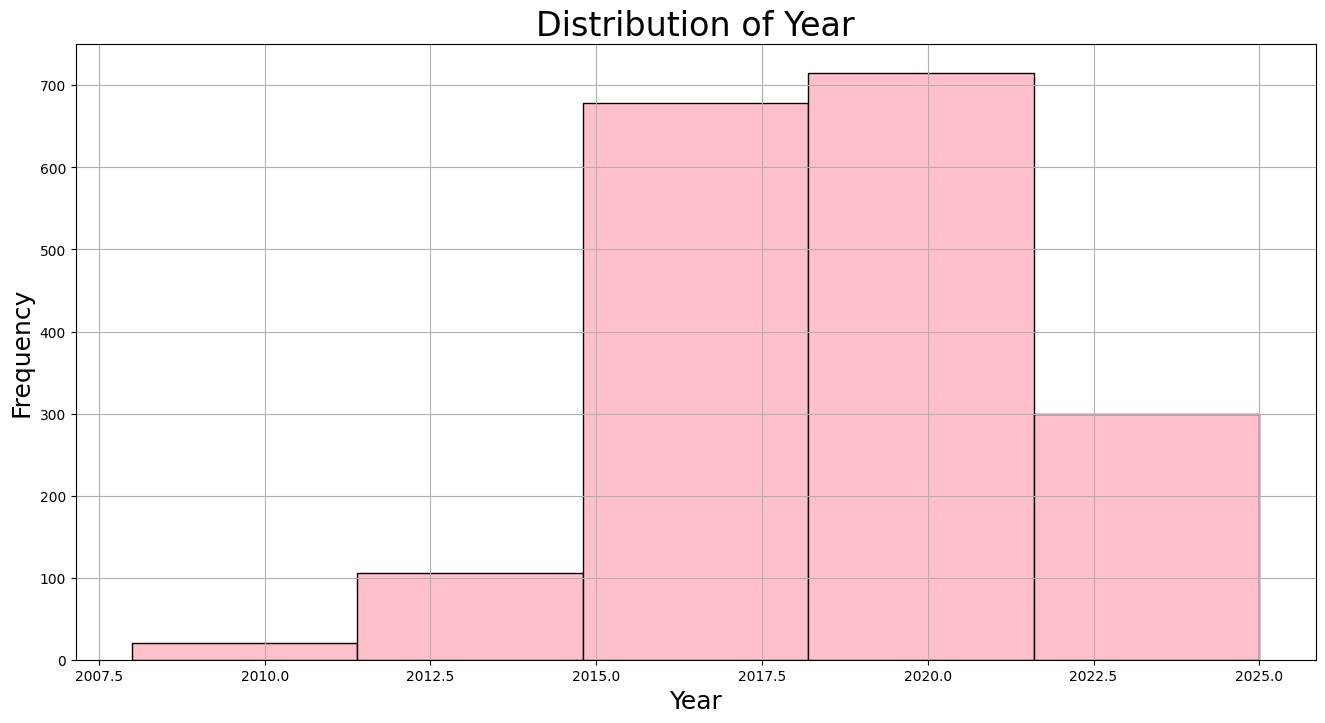

In [ ]:
df['Year'].plot(
    kind='hist',
    color='pink',
    edgecolor='black',
    bins=5,
    figsize=(16,8)
)

plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of Year', fontdict={'fontsize': 24})
plt.grid(True)
plt.show()

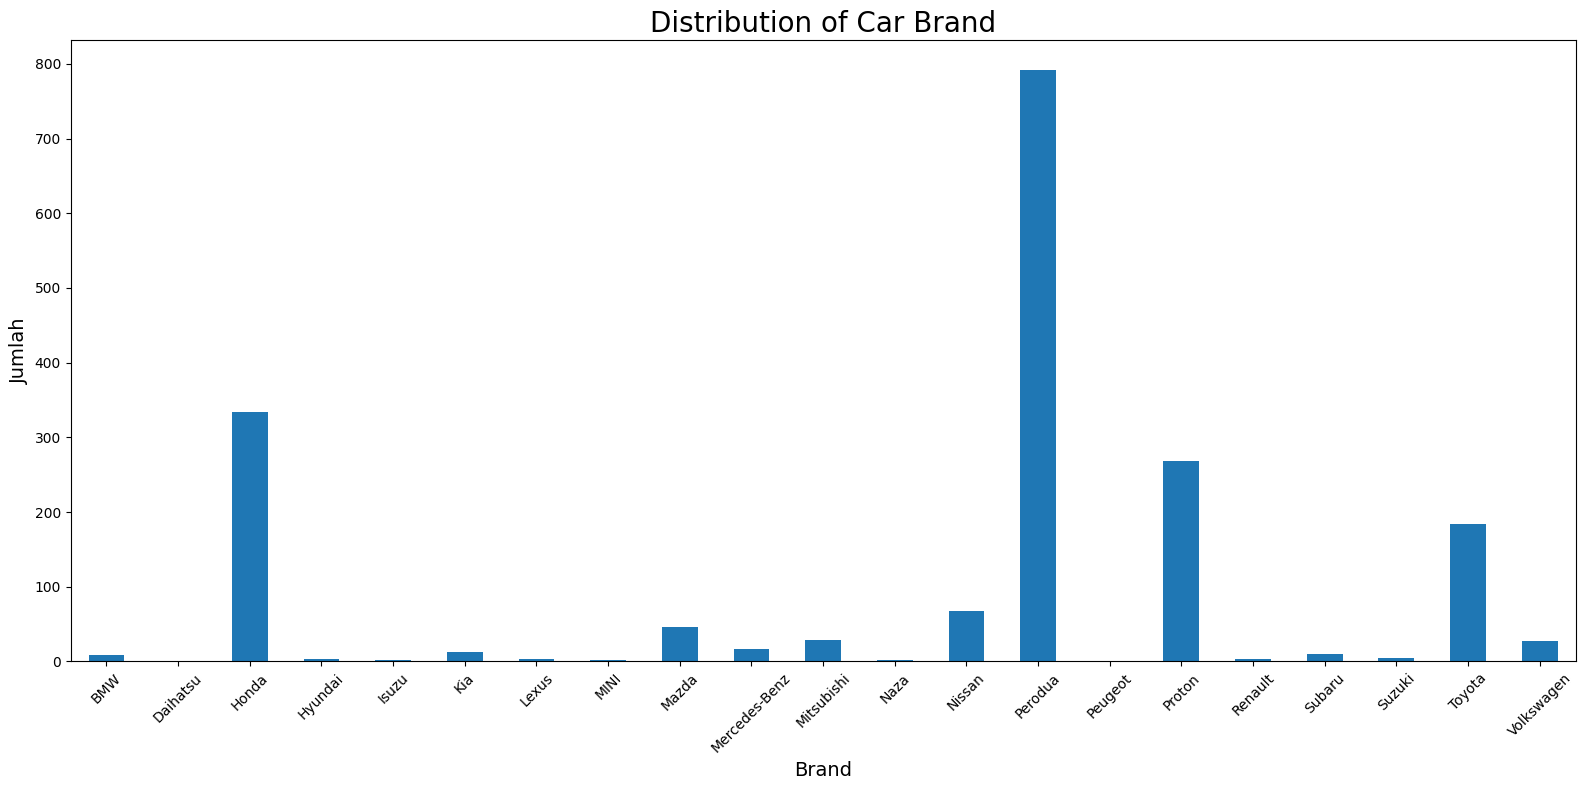

In [ ]:
df.groupby('Brand').size().plot.bar(figsize=(16, 8))
plt.title('Distribution of Car Brand', fontsize=20)
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

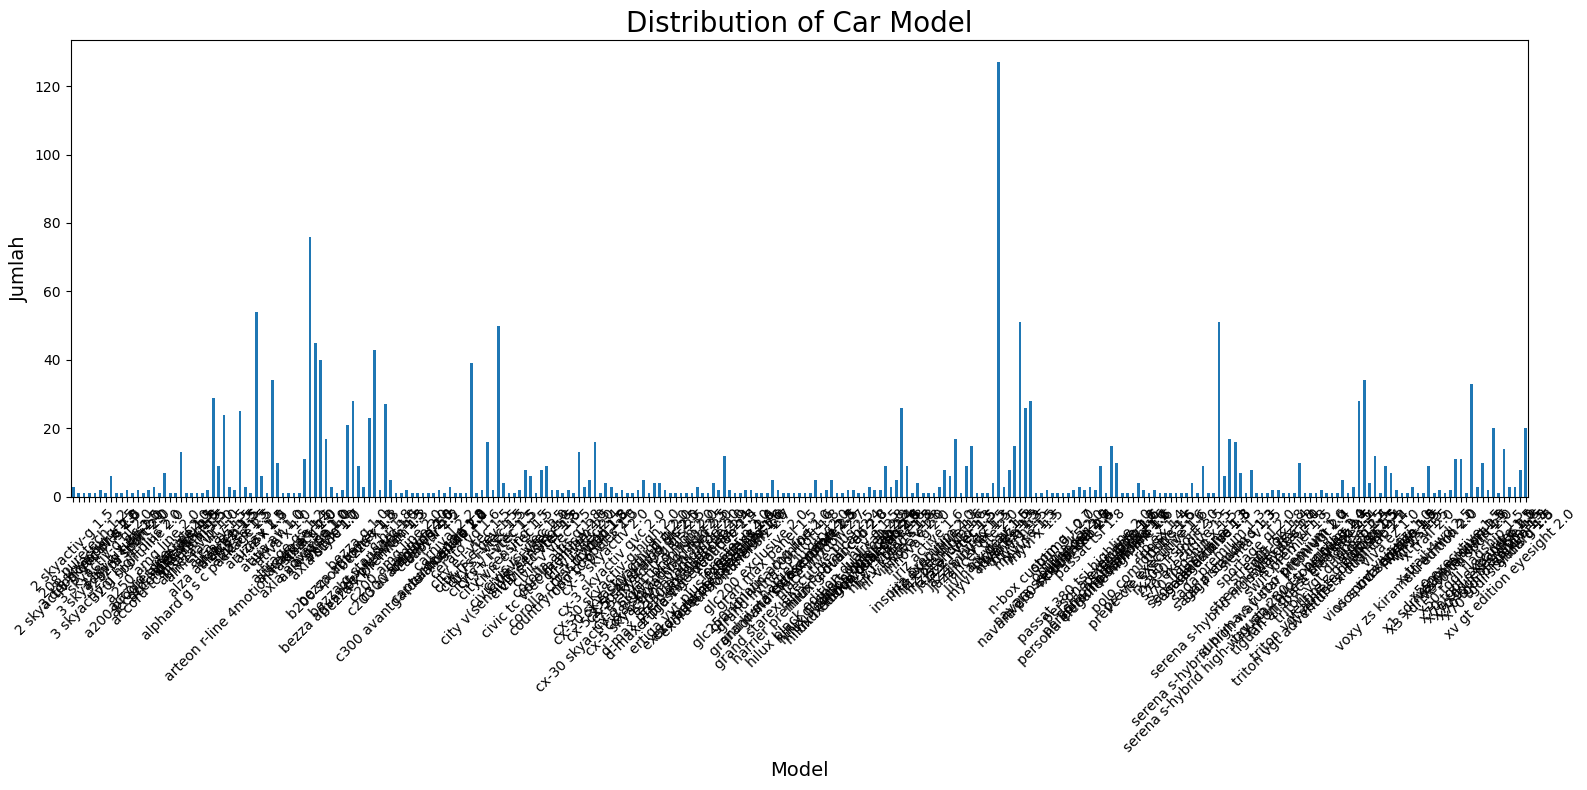

In [ ]:
df.groupby('Model').size().plot.bar(figsize=(16, 8))
plt.title('Distribution of Car Model', fontsize=20)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

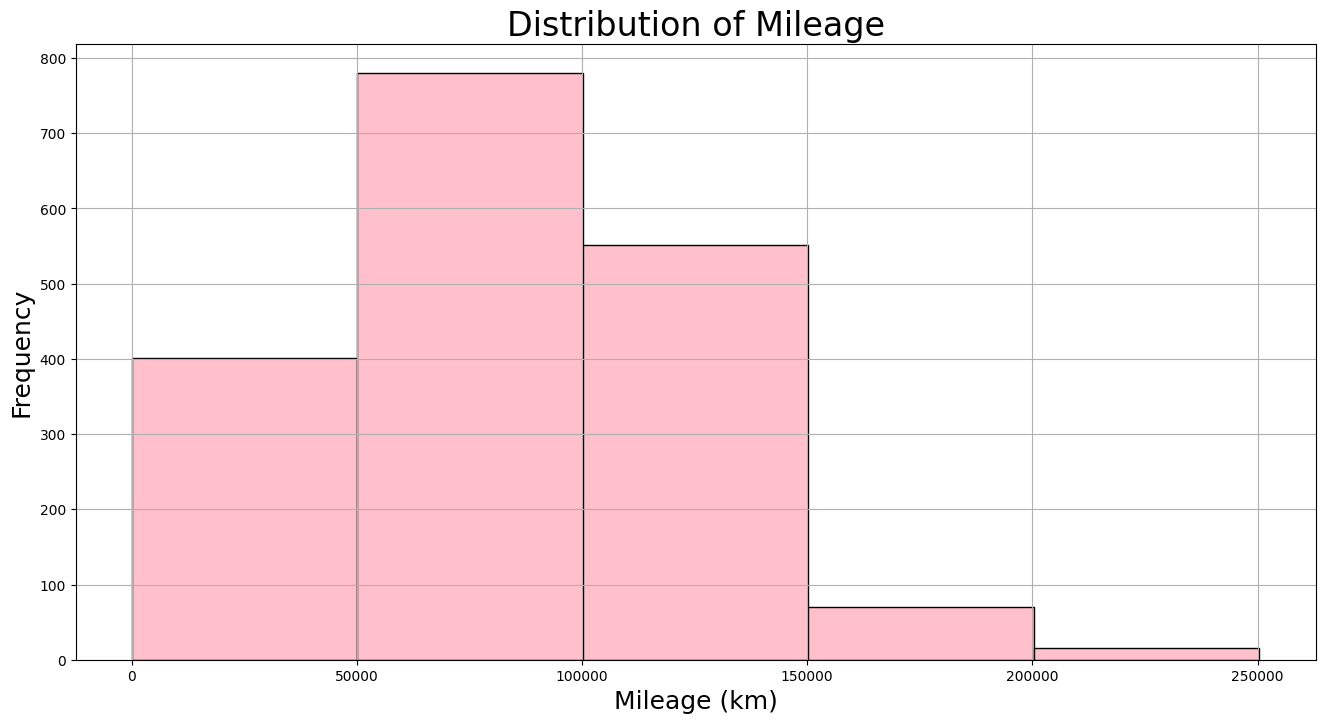

In [ ]:
df['Mileage(km)'].plot(
    kind='hist',
    color='pink',
    edgecolor='black',
    bins=5,
    figsize=(16,8)
)

plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Mileage (km)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of Mileage', fontdict={'fontsize': 24})
plt.grid(True)
plt.show()

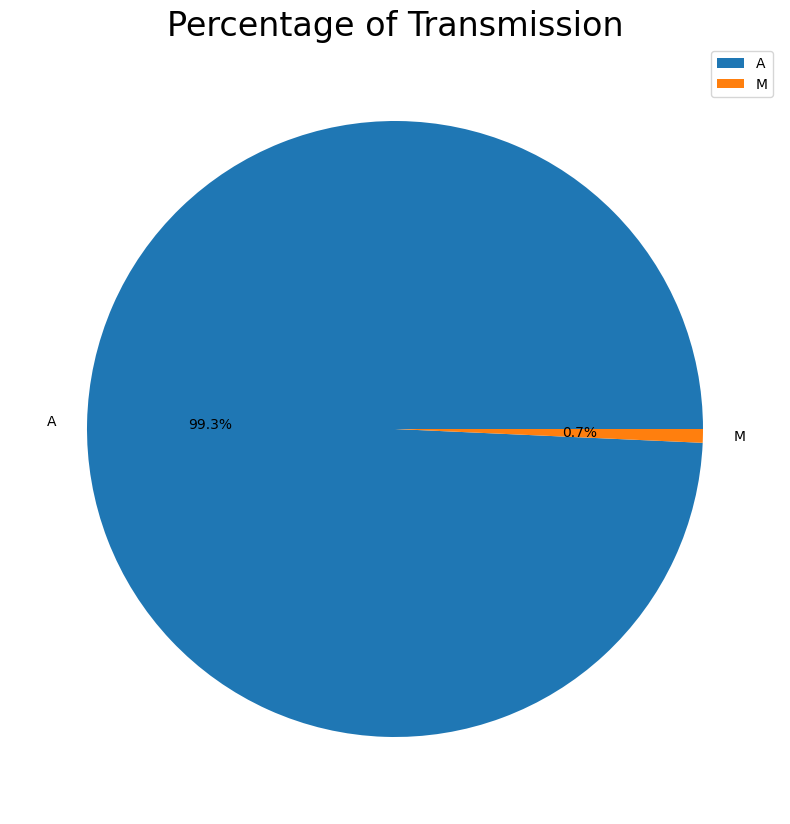

In [ ]:
df['Transmission'].value_counts().plot(kind='pie', label='', legend=True, autopct='%1.1f%%', figsize=(14,10))
plt.title("Percentage of Transmission", fontdict={'fontsize': 24})
plt.show()

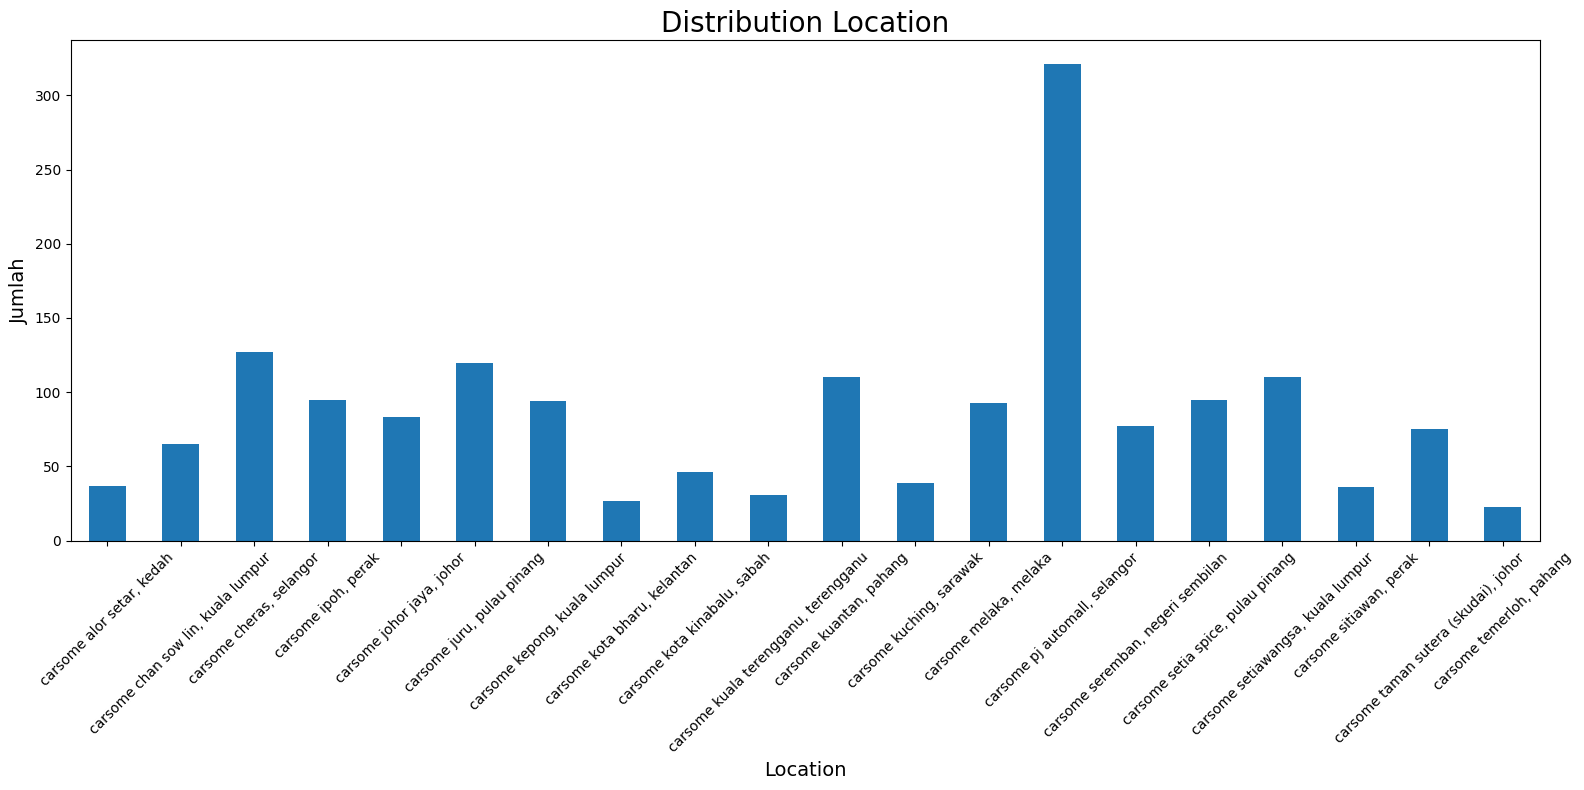

In [ ]:
df.groupby('Location').size().plot.bar(figsize=(16, 8))
plt.title('Distribution Location', fontsize=20)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

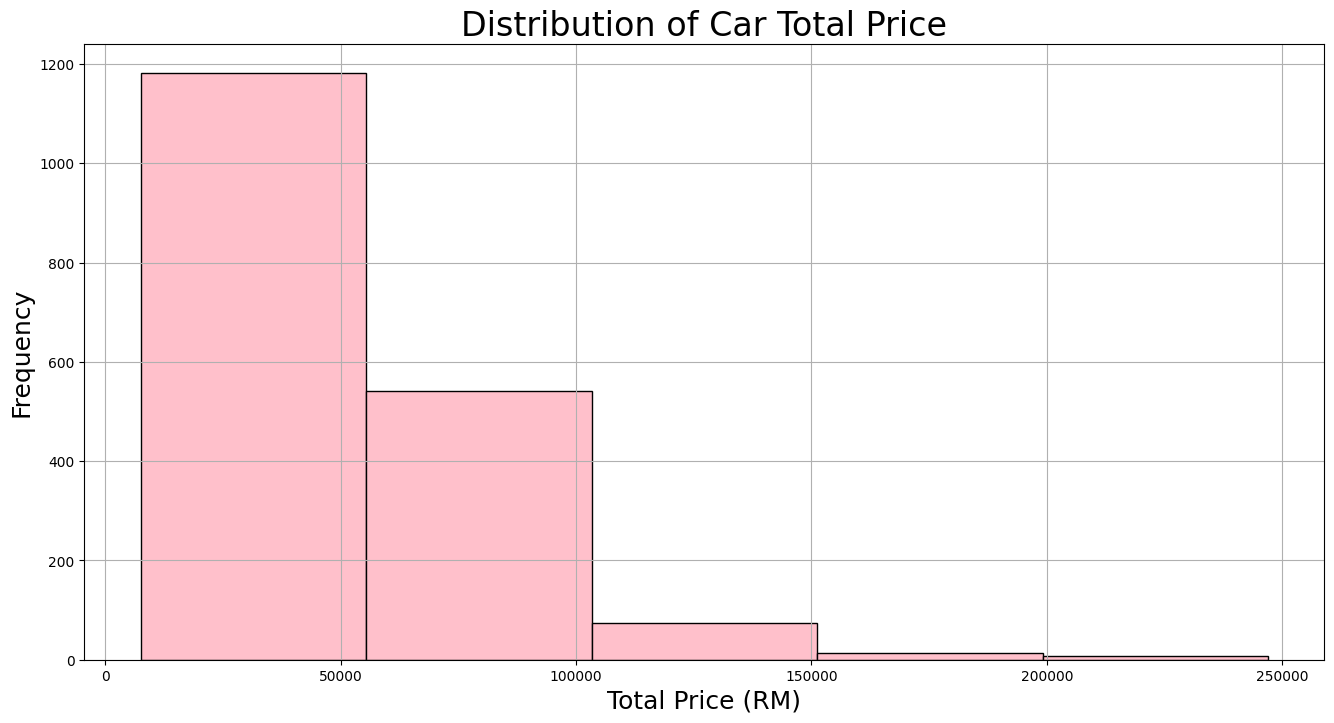

In [ ]:
df['Total_Price(RM)'].plot(
    kind='hist',
    color='pink',
    edgecolor='black',
    bins=5,
    figsize=(16,8)
)

plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Total Price (RM)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Distribution of Car Total Price', fontdict={'fontsize': 24})
plt.grid(True)
plt.show()

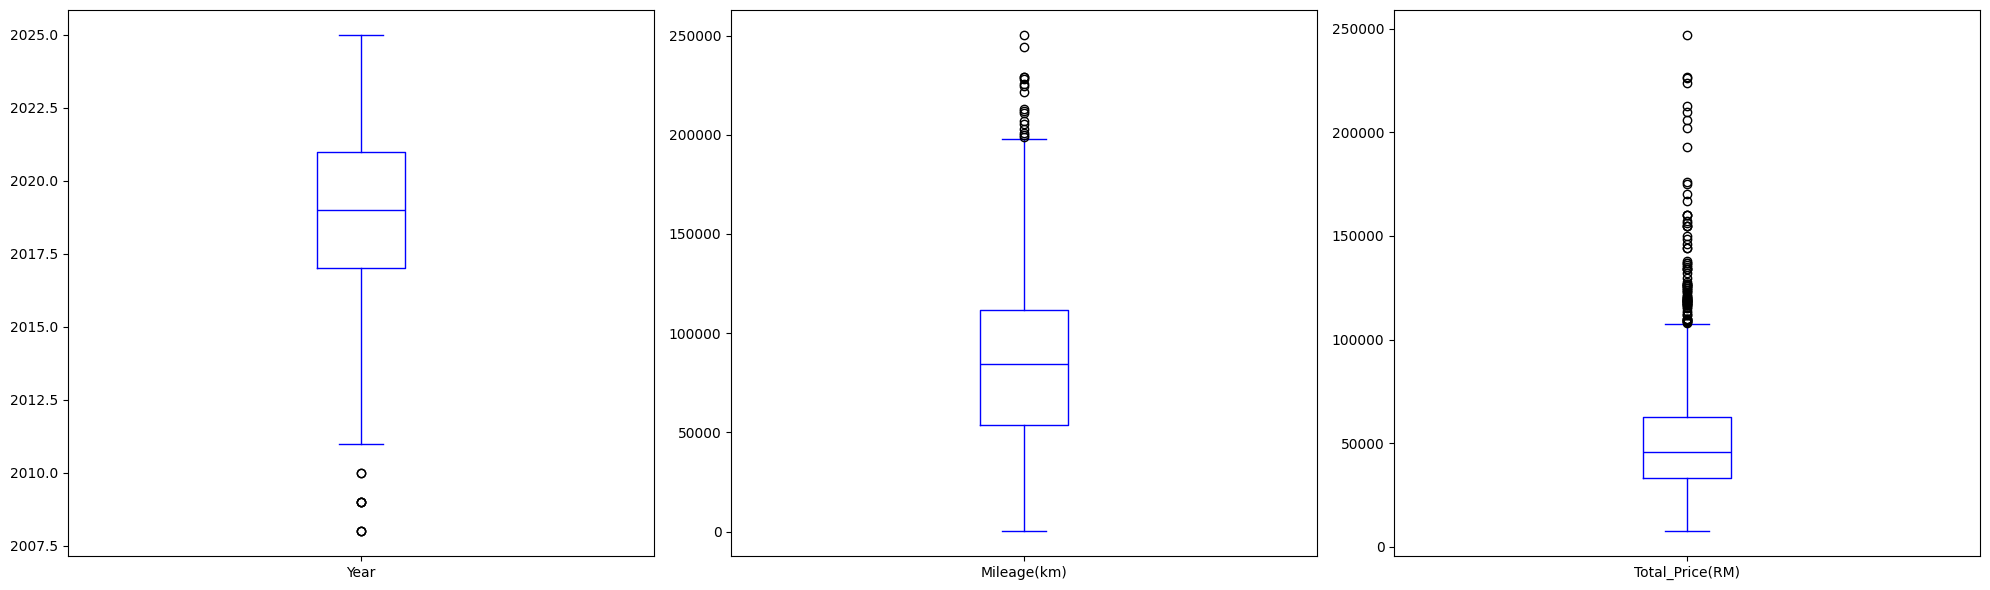

In [ ]:
# Buat daftar kolom numerik manual atau otomatis
numerical_col = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Sekarang plot boxplot
df[numerical_col].plot(
    kind='box',
    subplots=True,
    layout=(1, len(numerical_col)),
    sharex=False,
    sharey=False,
    figsize=(20, 6),
    color='blue'
)

plt.tight_layout()
plt.show()

## Data Transformed

1. Drop Outliers

In [ ]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_iqr(df, numerical_col)

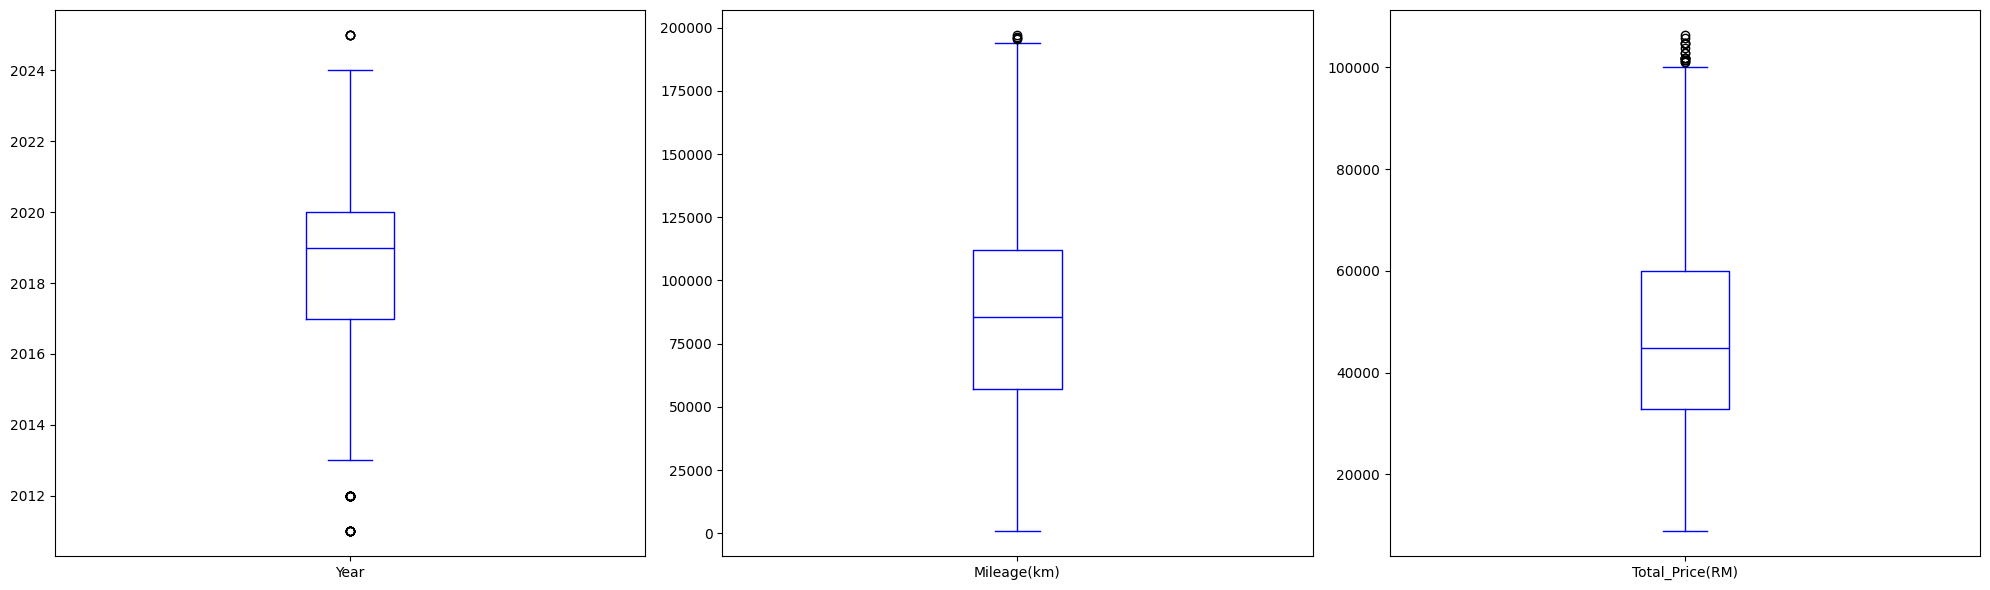

In [ ]:
numerical_col = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Sekarang plot boxplot
df[numerical_col].plot(
    kind='box',
    subplots=True,
    layout=(1, len(numerical_col)),
    sharex=False,
    sharey=False,
    figsize=(20, 6),
    color='blue'
)

plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1708 entries, 0 to 1817
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             1708 non-null   int64  
 1   Brand            1708 non-null   object 
 2   Model            1708 non-null   object 
 3   Mileage(km)      1708 non-null   float64
 4   Transmission     1708 non-null   object 
 5   Highlight        1708 non-null   object 
 6   Location         1604 non-null   object 
 7   Total_Price(RM)  1708 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 120.1+ KB


In [ ]:
df.isnull().sum()

,0
Year,0
Brand,0
Model,0
Mileage(km),0
Transmission,0
Highlight,0
Location,104
Total_Price(RM),0


In [ ]:
df = df.dropna()

In [ ]:
df

,Year,Brand,Model,Mileage(km),Transmission,Highlight,Location,Total_Price(RM)
0,2023,Honda,city e i-vtec 1.5,29544.0,A,daily drive,"carsome chan sow lin, kuala lumpur",67800.0
1,2023,Mazda,3 skyactiv-g 1.5,19307.0,A,upgrade daily drive,"carsome kepong, kuala lumpur",99400.0
2,2018,Honda,cr-v tc-p vtec 1.5,116245.0,A,compact suv,"carsome kuantan, pahang",86800.0
3,2016,Honda,jazz v i-vtec 1.5,129483.0,A,daily drive,"carsome taman sutera (skudai), johor",46000.0
4,2019,Perodua,myvi av 1.5,127997.0,A,national daily drive,"carsome johor jaya, johor",40800.0
...,...,...,...,...,...,...,...,...
1807,2018,Toyota,corolla altis g 1.8,84290.0,A,upgrade daily drive,"carsome pj automall, selangor",66400.0
1808,2020,Proton,persona standard 1.6,74178.0,A,national daily drive,"carsome setiawangsa, kuala lumpur",30400.0
1809,2014,Perodua,alza se 1.5,142668.0,A,family drive,"carsome pj automall, selangor",28900.0
1810,2015,Kia,rio sx 1.4,72187.0,A,daily drive,"carsome kuantan, pahang",25800.0


# Modelling

In [ ]:
num_features = ['Year', 'Mileage(km)']
cat_features = ['Brand', 'Model', 'Transmission', 'Location']

In [ ]:
X = df.drop(['Total_Price(RM)'], axis=1)
y = df['Total_Price(RM)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
y_train = np.log1p(y_train)

In [ ]:
num_transformer = Pipeline(steps=[
    ('power', PowerTransformer(method='box-cox')),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

cat_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [ ]:
pipe_RFR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

pipe_XGB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

pipe_LGBM = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

pipe_CatB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])

In [ ]:
pipe_RFR.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_RFR = np.expm1(pipe_RFR.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_RFR))
print("Test RMSE:", rmse)

Test RMSE: 8907.359881724575


In [ ]:
pipe_XGB.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_XGB = np.expm1(pipe_XGB.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_XGB))
print("Test RMSE:", rmse)

Test RMSE: 9494.865898153239


In [ ]:
pipe_LGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 1203, number of used features: 4
[LightGBM] [Info] Start training from score 10.708280


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_LGBM = np.expm1(pipe_LGBM.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_LGBM))
print("Test RMSE:", rmse)

Test RMSE: 9035.015012399735


In [ ]:
pipe_CatB.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_CatB = np.expm1(pipe_CatB.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_CatB))
print("Test RMSE:", rmse)

Test RMSE: 9140.739494671627


In [ ]:
rmse_RFR = np.sqrt(mean_squared_error(y_test, y_pred_RFR))
rmse_XGB = np.sqrt(mean_squared_error(y_test, y_pred_XGB))
rmse_LGBM = np.sqrt(mean_squared_error(y_test, y_pred_LGBM))
rmse_CatB = np.sqrt(mean_squared_error(y_test, y_pred_CatB))
print("Test RMSE RFR:", rmse_RFR)
print("Test RMSE XGB:", rmse_XGB)
print("Test RMSE LGBM:", rmse_LGBM)
print("Test RMSE CatB:", rmse_CatB)

Test RMSE RFR: 8907.359881724575
Test RMSE XGB: 9494.865898153239
Test RMSE LGBM: 9035.015012399735
Test RMSE CatB: 9140.739494671627


coba buat stacking model

In [ ]:
estimators = [
    ('rfr', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42))
]

meta_model = LinearRegression()

In [ ]:
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

pipe_all = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking', stack_model)
])

In [ ]:
pipe_all.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('stacking', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_all = np.expm1(pipe_all.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_all))
print("Test RMSE:", rmse)

Test RMSE: 8927.831146289293


In [ ]:
estimators = [
    ('rfr', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42))
]

meta_model = Ridge()

In [ ]:
stack_model1 = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

pipe_all1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking', stack_model1)
])

In [ ]:
pipe_all1.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('stacking', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_all1 = np.expm1(pipe_all1.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_all1))
print("Test RMSE:", rmse)

Test RMSE: 9005.67061687322


In [ ]:
estimators = [
    ('rfr', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42))
]

meta_model = Lasso()

In [ ]:
stack_model2 = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

pipe_all2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking', stack_model2)
])

In [ ]:
pipe_all2.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('stacking', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_all2 = np.expm1(pipe_all2.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_all2))
print("Test RMSE:", rmse)

Test RMSE: 18401.41763063368


## Tuning

In [ ]:
'''TODO: Gunakan GridSearch untuk memperbaiki proses'''
%timeit max(range(100000))
hyperparameter_space = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

# Inisiasi Gridsearch
Tune_RFR = RandomizedSearchCV(pipe_RFR, hyperparameter_space,
                              n_iter=100, random_state=42,
                              scoring = 'accuracy', cv=5,
                              n_jobs=-1, refit = True,
                              verbose=2)

# Jalankan Gridsearch
Tune_RFR.fit(X_train, y_train)

2.6 ms ± 86.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__max_depth': [None, 10, ...], 'model__max_features': ['sqrt', 'log2'], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,n_iter,100
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
Tune_RFR.best_params_, Tune_RFR.best_score_

({'model__n_estimators': 100,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 2,
  'model__max_features': 'log2',
  'model__max_depth': 30},
 np.float64(nan))

In [ ]:
'''TODO: Gunakan GridSearch untuk memperbaiki proses'''
%timeit max(range(100000))
hyperparameter_space = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_lambda': [1, 1.5, 2],
    'model__reg_alpha': [0, 0.5, 1]
}

# Inisiasi Gridsearch
Tune_XGB = RandomizedSearchCV(pipe_XGB, hyperparameter_space,
                              n_iter=100, random_state=42,
                              scoring = 'accuracy', cv=5,
                              n_jobs=-1, refit = True,
                              verbose=2)

# Jalankan Gridsearch
Tune_XGB.fit(X_train, y_train)

3.19 ms ± 869 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,"Pipeline(step...te=42, ...))])"
,param_distributions,"{'model__colsample_bytree': [0.6, 0.8, ...], 'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [3, 5, ...], 'model__n_estimators': [100, 300, ...], ...}"
,n_iter,100
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
Tune_XGB.best_params_, Tune_XGB.best_score_

({'model__subsample': 0.8,
  'model__reg_lambda': 1,
  'model__reg_alpha': 0.5,
  'model__n_estimators': 500,
  'model__max_depth': 5,
  'model__learning_rate': 0.05,
  'model__colsample_bytree': 1.0},
 np.float64(nan))

In [ ]:
'''TODO: Gunakan GridSearch untuk memperbaiki proses'''
%timeit max(range(100000))
hyperparameter_space = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [-1, 10, 20],
    'model__num_leaves': [31, 50, 100],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_lambda': [0, 1, 2],
    'model__reg_alpha': [0, 1, 2]
}

# Inisiasi Gridsearch
Tune_LGBM = RandomizedSearchCV(pipe_LGBM, hyperparameter_space,
                              n_iter=100, random_state=42,
                              scoring = 'accuracy', cv=5,
                              n_jobs=-1, refit = True,
                              verbose=2)

# Jalankan Gridsearch
Tune_LGBM.fit(X_train, y_train)

3.42 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 1281, number of used features: 4
[LightGBM] [Info] Start training from score 48496.799375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__colsample_bytree': [0.6, 0.8, ...], 'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [-1, 10, ...], 'model__n_estimators': [100, 300, ...], ...}"
,n_iter,100
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
Tune_LGBM.best_params_, Tune_LGBM.best_score_

({'model__subsample': 1.0,
  'model__reg_lambda': 0,
  'model__reg_alpha': 0,
  'model__num_leaves': 100,
  'model__n_estimators': 500,
  'model__max_depth': 20,
  'model__learning_rate': 0.05,
  'model__colsample_bytree': 0.6},
 np.float64(nan))

In [ ]:
'''TODO: Gunakan GridSearch untuk memperbaiki proses'''
%timeit max(range(100000))
hyperparameter_space = {
    'model__iterations': [300, 500, 800],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 10],
    'model__l2_leaf_reg': [1, 3, 5],
    'model__border_count': [32, 64, 128]
}

# Inisiasi Gridsearch
Tune_CatB = RandomizedSearchCV(pipe_CatB, hyperparameter_space,
                              n_iter=100, random_state=42,
                              scoring = 'accuracy', cv=5,
                              n_jobs=-1, refit = True,
                              verbose=2)

# Jalankan Gridsearch
Tune_CatB.fit(X_train, y_train)

3.54 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step...d9c53c2550>)])
,param_distributions,"{'model__border_count': [32, 64, ...], 'model__depth': [4, 6, ...], 'model__iterations': [300, 500, ...], 'model__l2_leaf_reg': [1, 3, ...], ...}"
,n_iter,100
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
Tune_CatB.best_params_, Tune_CatB.best_score_

({'model__learning_rate': 0.01,
  'model__l2_leaf_reg': 5,
  'model__iterations': 800,
  'model__depth': 4,
  'model__border_count': 32},
 np.float64(nan))

In [ ]:
rmse_RFR = np.sqrt(mean_squared_error(y_test, y_pred_RFR))
rmse_XGB = np.sqrt(mean_squared_error(y_test, y_pred_XGB))
rmse_LGBM = np.sqrt(mean_squared_error(y_test, y_pred_LGBM))
rmse_CatB = np.sqrt(mean_squared_error(y_test, y_pred_CatB))
print("Test RMSE RFR:", rmse_RFR)
print("Test RMSE XGB:", rmse_XGB)
print("Test RMSE LGBM:", rmse_LGBM)
print("Test RMSE CatB:", rmse_CatB)

Test RMSE RFR: 9286.61893157719
Test RMSE XGB: 9496.044216956532
Test RMSE LGBM: 9452.649963879168
Test RMSE CatB: 8883.597570144368


In [ ]:
RFR = RandomForestRegressor(random_state=42, n_estimators= 100, min_samples_split= 5, min_samples_leaf= 2, max_features= 'log2', max_depth= 30)
XGB = XGBRegressor(random_state=42, subsample= 0.8, reg_lambda= 1, reg_alpha= 0.5, n_estimators= 500, max_depth= 5, learning_rate= 0.05, colsample_bytree= 1.0)
LGBM = LGBMRegressor(random_state=42, subsample= 1.0, reg_lambda= 0, reg_alpha= 0, num_leaves= 100, n_estimators= 500, max_depth= 20, learning_rate= 0.05, colsample_bytree= 0.6)
CatB = CatBoostRegressor(verbose=0, random_state=42, learning_rate= 0.01, l2_leaf_reg= 5, iterations= 800, depth= 4, border_count= 32)

In [ ]:
tune_pipe_RFR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler()),
    ('model', RFR)
])

tune_pipe_XGB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler()),
    ('model', XGB)
])

tune_pipe_LGBM = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler()),
    ('model', LGBM)
])

tune_pipe_CatB = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler()),
    ('model', CatB)
])

In [ ]:
tune_pipe_RFR.fit(X_train, y_train)
tune_pipe_XGB.fit(X_train, y_train)
tune_pipe_LGBM.fit(X_train, y_train)
tune_pipe_CatB.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 1281, number of used features: 4
[LightGBM] [Info] Start training from score 48496.799375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
tune_pred_RFR = tune_pipe_RFR.predict(X_test)
tune_pred_XGB = tune_pipe_XGB.predict(X_test)
tune_pred_LGBM = tune_pipe_LGBM.predict(X_test)
tune_pred_CatB = tune_pipe_CatB.predict(X_test)

In [ ]:
rmse_RFR = np.sqrt(mean_squared_error(y_test, y_pred_RFR))
rmse_XGB = np.sqrt(mean_squared_error(y_test, y_pred_XGB))
rmse_LGBM = np.sqrt(mean_squared_error(y_test, y_pred_LGBM))
rmse_CatB = np.sqrt(mean_squared_error(y_test, y_pred_CatB))
rmse_RFR_final = np.sqrt(mean_squared_error(y_test, tune_pred_RFR))
rmse_XGB_final = np.sqrt(mean_squared_error(y_test, tune_pred_XGB))
rmse_LGBM_final = np.sqrt(mean_squared_error(y_test, tune_pred_LGBM))
rmse_CatB_final = np.sqrt(mean_squared_error(y_test, tune_pred_CatB))
print("Test RMSE RFR:", rmse_RFR)
print("Test RMSE XGB:", rmse_XGB)
print("Test RMSE LGBM:", rmse_LGBM)
print("Test RMSE CatB:", rmse_CatB)
print("Test RMSE RFR final:", rmse_RFR_final)
print("Test RMSE XGB final:", rmse_XGB_final)
print("Test RMSE LGBM final:", rmse_LGBM_final)
print("Test RMSE CatB final:", rmse_CatB_final)

Test RMSE RFR: 9286.61893157719
Test RMSE XGB: 9496.044216956532
Test RMSE LGBM: 9452.649963879168
Test RMSE CatB: 8883.597570144368
Test RMSE RFR final: 10335.781800714252
Test RMSE XGB final: 9298.318849057468
Test RMSE LGBM final: 9559.921966562579
Test RMSE CatB final: 10814.388330042868


In [ ]:
def objective(trial):
    # Param untuk base learners
    rfr_params = {
        'n_estimators': trial.suggest_categorical('rfr__n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_categorical('rfr__max_depth', [None, 10, 20, 30]),
        'min_samples_split': trial.suggest_categorical('rfr__min_samples_split', [2, 5, 10]),
        'min_samples_leaf': trial.suggest_categorical('rfr__min_samples_leaf', [1, 2, 4]),
        'max_features': trial.suggest_categorical('rfr__max_features', ['sqrt', 'log2'])
    }

    xgb_params = {
        'n_estimators': trial.suggest_categorical('xgb__n_estimators', [100, 300, 500]),
        'learning_rate': trial.suggest_categorical('xgb__learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_categorical('xgb__max_depth', [3, 5, 7]),
        'subsample': trial.suggest_categorical('xgb__subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('xgb__colsample_bytree', [0.6, 0.8, 1.0]),
        'reg_lambda': trial.suggest_categorical('xgb__reg_lambda', [1, 1.5, 2]),
        'reg_alpha': trial.suggest_categorical('xgb__reg_alpha', [0, 0.5, 1])
    }

    lgbm_params = {
        'n_estimators': trial.suggest_categorical('lgbm__n_estimators', [100, 300, 500]),
        'learning_rate': trial.suggest_categorical('lgbm__learning_rate', [0.01, 0.05, 0.1]),
        'max_depth': trial.suggest_categorical('lgbm__max_depth', [-1, 10, 20]),
        'num_leaves': trial.suggest_categorical('lgbm__num_leaves', [31, 50, 100]),
        'subsample': trial.suggest_categorical('lgbm__subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('lgbm__colsample_bytree', [0.6, 0.8, 1.0]),
        'reg_lambda': trial.suggest_categorical('lgbm__reg_lambda', [0, 1, 2]),
        'reg_alpha': trial.suggest_categorical('lgbm__reg_alpha', [0, 1, 2])
    }

    cat_params = {
        'iterations': trial.suggest_categorical('cat__iterations', [300, 500, 800]),
        'learning_rate': trial.suggest_categorical('cat__learning_rate', [0.01, 0.05, 0.1]),
        'depth': trial.suggest_categorical('cat__depth', [4, 6, 10]),
        'l2_leaf_reg': trial.suggest_categorical('cat__l2_leaf_reg', [1, 3, 5]),
        'border_count': trial.suggest_categorical('cat__border_count', [32, 64, 128]),
        'verbose': 0
    }

    final_estimator_alpha = trial.suggest_categorical('final_alpha', [0.1, 0.5, 1.0])

    # Inisialisasi model
    rfr = RandomForestRegressor(**rfr_params, random_state=42)
    xgb = XGBRegressor(**xgb_params, random_state=42)
    lgbm = LGBMRegressor(**lgbm_params, random_state=42)
    cat = CatBoostRegressor(**cat_params, random_state=42)

    estimators = [
        ('rfr', rfr),
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('cat', cat)
    ]

    stack_model = StackingRegressor(
        estimators=estimators,
        final_estimator=Ridge(alpha=final_estimator_alpha),
        n_jobs=-1
    )

    # Pipeline akhir
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),  # pastikan sudah didefinisikan
        ('model', stack_model)
    ])

    # K-Fold CV
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

    return -np.mean(scores)


In [ ]:
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=500, timeout=8100)

print("Best trial:")
print(study.best_trial)

[I 2025-07-13 14:36:27,417] A new study created in memory with name: no-name-9408de8a-3252-4355-a538-4479bddba31e
[I 2025-07-13 14:36:44,210] Trial 0 finished with value: 0.1945669549915705 and parameters: {'rfr__n_estimators': 200, 'rfr__max_depth': None, 'rfr__min_samples_split': 2, 'rfr__min_samples_leaf': 2, 'rfr__max_features': 'sqrt', 'xgb__n_estimators': 500, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__subsample': 0.8, 'xgb__colsample_bytree': 0.8, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.5, 'lgbm__n_estimators': 500, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 10, 'lgbm__num_leaves': 31, 'lgbm__subsample': 1.0, 'lgbm__colsample_bytree': 0.8, 'lgbm__reg_lambda': 1, 'lgbm__reg_alpha': 2, 'cat__iterations': 800, 'cat__learning_rate': 0.1, 'cat__depth': 6, 'cat__l2_leaf_reg': 1, 'cat__border_count': 64, 'final_alpha': 0.5}. Best is trial 0 with value: 0.1945669549915705.
[I 2025-07-13 14:37:10,544] Trial 1 finished with value: 0.20318906888564672 and parameters: {'rfr

Best trial:
FrozenTrial(number=491, state=1, values=[0.1890597008807524], datetime_start=datetime.datetime(2025, 7, 13, 16, 24, 57, 680954), datetime_complete=datetime.datetime(2025, 7, 13, 16, 25, 10, 368297), params={'rfr__n_estimators': 300, 'rfr__max_depth': 20, 'rfr__min_samples_split': 5, 'rfr__min_samples_leaf': 1, 'rfr__max_features': 'log2', 'xgb__n_estimators': 300, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__subsample': 1.0, 'xgb__colsample_bytree': 0.6, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0, 'lgbm__n_estimators': 300, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__num_leaves': 31, 'lgbm__subsample': 0.6, 'lgbm__colsample_bytree': 1.0, 'lgbm__reg_lambda': 1, 'lgbm__reg_alpha': 2, 'cat__iterations': 500, 'cat__learning_rate': 0.1, 'cat__depth': 4, 'cat__l2_leaf_reg': 1, 'cat__border_count': 128, 'final_alpha': 0.1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rfr__n_estimators': CategoricalDistribution(choices=(100, 200, 30

In [ ]:
best_params = study.best_trial.params

# Random Forest
rfr_best = RandomForestRegressor(
    n_estimators=best_params['rfr__n_estimators'],
    max_depth=best_params['rfr__max_depth'],
    min_samples_split=best_params['rfr__min_samples_split'],
    min_samples_leaf=best_params['rfr__min_samples_leaf'],
    max_features=best_params['rfr__max_features'],
    random_state=42
)

# XGBoost
xgb_best = XGBRegressor(
    n_estimators=best_params['xgb__n_estimators'],
    learning_rate=best_params['xgb__learning_rate'],
    max_depth=best_params['xgb__max_depth'],
    subsample=best_params['xgb__subsample'],
    colsample_bytree=best_params['xgb__colsample_bytree'],
    reg_lambda=best_params['xgb__reg_lambda'],
    reg_alpha=best_params['xgb__reg_alpha'],
    random_state=42
)

# LightGBM
lgbm_best = LGBMRegressor(
    n_estimators=best_params['lgbm__n_estimators'],
    learning_rate=best_params['lgbm__learning_rate'],
    max_depth=best_params['lgbm__max_depth'],
    num_leaves=best_params['lgbm__num_leaves'],
    subsample=best_params['lgbm__subsample'],
    colsample_bytree=best_params['lgbm__colsample_bytree'],
    reg_lambda=best_params['lgbm__reg_lambda'],
    reg_alpha=best_params['lgbm__reg_alpha'],
    random_state=42
)

# CatBoost
cat_best = CatBoostRegressor(
    iterations=best_params['cat__iterations'],
    learning_rate=best_params['cat__learning_rate'],
    depth=best_params['cat__depth'],
    l2_leaf_reg=best_params['cat__l2_leaf_reg'],
    border_count=best_params['cat__border_count'],
    verbose=0,
    random_state=42
)

# Stacking Regressor
stack_best = StackingRegressor(
    estimators=[
        ('rfr', rfr_best),
        ('xgb', xgb_best),
        ('lgbm', lgbm_best),
        ('cat', cat_best)
    ],
    final_estimator=Ridge(alpha=best_params['final_alpha'])
)

# Final Pipeline
final_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', stack_best)
])

# Fit model
final_pipe_fit = final_pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 1203, number of used features: 4
[LightGBM] [Info] Start training from score 10.708280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
tune_pred_final_pipe = np.expm1(final_pipe.predict(X_test))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, tune_pred_final_pipe))
print("Test RMSE:", rmse)

Test RMSE: 8807.98238857931


In [ ]:
'''TODO: Silahkan simpan model yang kamu miliki'''
import pickle
# Menyimpan model terbaik dengan pickle
pklname = "best_regression.pkl"

with open(pklname, 'wb') as file:
    pickle.dump(final_pipe_fit, file)

files.download(pklname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.head()

,Year,Brand,Model,Mileage(km),Transmission,Highlight,Location,Total_Price(RM)
0,2023,honda,city e i-vtec 1.5,29544.0,A,daily drive,"carsome chan sow lin, kuala lumpur",67800.0
1,2023,mazda,3 skyactiv-g 1.5,19307.0,A,upgrade daily drive,"carsome kepong, kuala lumpur",99400.0
2,2018,honda,cr-v tc-p vtec 1.5,116245.0,A,compact suv,"carsome kuantan, pahang",86800.0
3,2016,honda,jazz v i-vtec 1.5,129483.0,A,daily drive,"carsome taman sutera (skudai), johor",46000.0
4,2019,perodua,myvi av 1.5,127997.0,A,national daily drive,"carsome johor jaya, johor",40800.0


In [ ]:
sorted(df['Year'].unique())

[np.int64(2008),
 np.int64(2009),
 np.int64(2010),
 np.int64(2011),
 np.int64(2012),
 np.int64(2013),
 np.int64(2014),
 np.int64(2015),
 np.int64(2016),
 np.int64(2017),
 np.int64(2018),
 np.int64(2019),
 np.int64(2020),
 np.int64(2021),
 np.int64(2022),
 np.int64(2023),
 np.int64(2024),
 np.int64(2025)]

In [47]:
df['Brand'].unique()

array(['Honda', 'Mazda', 'Perodua', 'Mercedes-Benz', 'Toyota', 'Subaru',
       'Proton', 'Nissan', 'BMW', 'Mitsubishi', 'Lexus', 'Volkswagen',
       'Kia', 'Hyundai', 'Daihatsu', 'Peugeot', 'Suzuki', 'Renault',
       'MINI', 'Naza', 'Isuzu'], dtype=object)

In [ ]:
df['Model'].unique()

array(['city e i-vtec 1.5', '3 skyactiv-g 1.5', 'cr-v tc-p vtec 1.5',
       'jazz v i-vtec 1.5', 'myvi av 1.5', 'civic tc vtec premium 1.5',
       'a250 amg line 2.0', 'sienta v 1.5', 'vios j 1.5',
       'axia gxtra 1.0', 'alza advance 1.5', 'alza se 1.5',
       'bezza advance premium 1.3', 'myvi h 1.5', 'xv p 2.0',
       'suprima s turbo premium 1.6', 'city v sensing 1.5',
       'axia style 1.0', 'almera e 1.5', 'saga premium 1.3',
       'grand livina comfort 1.6', '320i m sport 2.0',
       'city v i-vtec 1.5', 'cr-v tc vtec 1.5', 'aruz av 1.5',
       'myvi se 1.5', 'xpander 1.5', 'axia se 1.0', 'city s i-vtec 1.5',
       'myvi g 1.3', 'hr-v v 1.5', 'x70 tgdi premium 1.8',
       'jazz e i-vtec 1.5', 'bezza x premium 1.3',
       'x50 tgdi flagship 1.5', 'ativa h 1.0', 'jazz s i-vtec 1.5',
       'cx-5 skyactiv-g high 2.0', 'vellfire z g edition 2.5',
       'hr-v i-vtec rs 1.8', 'hr-v i-vtec v 1.8', 'ativa av 1.0',
       'almera vlp 1.0', 'xv gt edition eyesight 2.0', 'axi

In [ ]:
sorted(df['Mileage(km)'].unique())

[np.float64(109.0),
 np.float64(112.0),
 np.float64(123.0),
 np.float64(782.0),
 np.float64(1033.0),
 np.float64(2428.0),
 np.float64(2877.0),
 np.float64(2978.0),
 np.float64(3154.0),
 np.float64(3209.0),
 np.float64(3454.0),
 np.float64(4175.0),
 np.float64(5788.0),
 np.float64(6096.0),
 np.float64(6627.0),
 np.float64(6715.0),
 np.float64(6729.0),
 np.float64(7126.0),
 np.float64(7442.0),
 np.float64(7695.0),
 np.float64(7726.0),
 np.float64(8511.0),
 np.float64(8772.0),
 np.float64(8819.0),
 np.float64(9187.0),
 np.float64(9229.0),
 np.float64(9307.0),
 np.float64(9850.0),
 np.float64(9857.0),
 np.float64(9949.0),
 np.float64(9999.0),
 np.float64(10369.0),
 np.float64(10769.0),
 np.float64(11102.0),
 np.float64(11150.0),
 np.float64(11612.0),
 np.float64(11713.0),
 np.float64(11910.0),
 np.float64(11964.0),
 np.float64(12072.0),
 np.float64(12087.0),
 np.float64(12305.0),
 np.float64(12342.0),
 np.float64(12461.0),
 np.float64(12833.0),
 np.float64(12857.0),
 np.float64(12879.0),
 

In [ ]:
sorted(df['Mileage(km)'].unique(), reverse=True)

[np.float64(250364.0),
 np.float64(244036.0),
 np.float64(229340.0),
 np.float64(229272.0),
 np.float64(227876.0),
 np.float64(225433.0),
 np.float64(224437.0),
 np.float64(221549.0),
 np.float64(212915.0),
 np.float64(211746.0),
 np.float64(210985.0),
 np.float64(206691.0),
 np.float64(205384.0),
 np.float64(202806.0),
 np.float64(200897.0),
 np.float64(199993.0),
 np.float64(198720.0),
 np.float64(197666.0),
 np.float64(197141.0),
 np.float64(196411.0),
 np.float64(195771.0),
 np.float64(195300.0),
 np.float64(194031.0),
 np.float64(191637.0),
 np.float64(187415.0),
 np.float64(186132.0),
 np.float64(184267.0),
 np.float64(183366.0),
 np.float64(183217.0),
 np.float64(182988.0),
 np.float64(182503.0),
 np.float64(180781.0),
 np.float64(180298.0),
 np.float64(180074.0),
 np.float64(180057.0),
 np.float64(179766.0),
 np.float64(178539.0),
 np.float64(178192.0),
 np.float64(176464.0),
 np.float64(175951.0),
 np.float64(174757.0),
 np.float64(174271.0),
 np.float64(174027.0),
 np.float64

In [ ]:
df['Highlight'].unique()

array(['daily drive', 'upgrade daily drive', 'compact suv',
       'national daily drive', 'luxury', 'family drive', 'executive',
       'adventure', 'commercial'], dtype=object)

In [ ]:
df['Location'].unique()

array(['carsome chan sow lin, kuala lumpur',
       'carsome kepong, kuala lumpur', 'carsome kuantan, pahang',
       'carsome taman sutera (skudai), johor',
       'carsome johor jaya, johor', 'carsome juru, pulau pinang',
       'carsome cheras, selangor', 'carsome pj automall, selangor',
       'carsome melaka, melaka', 'carsome kota kinabalu, sabah',
       'carsome alor setar, kedah',
       'carsome kuala terengganu, terengganu', 'carsome temerloh, pahang',
       'carsome setiawangsa, kuala lumpur', 'carsome sitiawan, perak',
       'carsome ipoh, perak', 'carsome seremban, negeri sembilan',
       'carsome setia spice, pulau pinang',
       'carsome kota bharu, kelantan', 'carsome kuching, sarawak', nan],
      dtype=object)